In [1]:
import copy
import os
import re
import warnings
from collections import defaultdict

import pandas as pd
import torch
import torch.nn as nn
from tabulate import tabulate
from torch.optim import SGD
from tqdm import tqdm
from vbfml.training.input import build_sequence, load_datasets_bucoffea
from vbfml.training.util import normalize_classes, save, select_and_label_datasets
from vbfml.training.data import TrainingLoader
from vbfml.util import vbfml_path
import click
from datetime import datetime

2022-02-15 15:33:29.207453: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/albert/repos/xrootd/install/lib:/home/albert/repos/xrootd/install/lib:/home/albert/repos/xrootd/install/lib
2022-02-15 15:33:29.207476: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib
%matplotlib inline

pd.options.display.float_format = '{:,.2f}'.format
matplotlib.rcParams['figure.figsize'] = (7, 5)
font = {'size'   : 18}
matplotlib.rc('font', **font)
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 150

In [3]:
input_dir = "/data/cms/vbfml/2021-08-25_treesForML_v2/"

In [4]:
all_datasets = load_datasets_bucoffea(input_dir)

dataset_labels = {
    "ewk_17": "(EWK.*2017|VBF_HToInvisible_M125_withDipoleRecoil_pow_pythia8_2017)",
    "v_qcd_nlo_17": "(WJetsToLNu_Pt-\d+To.*|Z\dJetsToNuNu_M-50_LHEFilterPtZ-\d+To\d+)_MatchEWPDG20-amcatnloFXFX_2017",
}
datasets = select_and_label_datasets(all_datasets, dataset_labels)
# for dataset_info in datasets:
#     if re.match(dataset_labels["v_qcd_nlo_17"], dataset_info.name):
#         dataset_info.n_events = 0.2 * dataset_info.n_events
features = [
    "mjj",
    "dphijj",
    "detajj",
    "mjj_maxmjj",
    "dphijj_maxmjj",
    "detajj_maxmjj",
    "recoil_pt",
    "dphi_ak40_met",
    "dphi_ak41_met",
    "ht",
    "leadak4_pt",
    "leadak4_eta",
    "trailak4_pt",
    "trailak4_eta",
    "leadak4_mjjmax_pt",
    "leadak4_mjjmax_eta",
    "trailak4_mjjmax_pt",
    "trailak4_mjjmax_eta",
]

training_sequence = build_sequence(
    datasets=copy.deepcopy(datasets),
    features=features,
    weight_expression="weight_total*xs/sumw",
)
validation_sequence = build_sequence(
    datasets=copy.deepcopy(datasets),
    features=features,
    weight_expression="weight_total*xs/sumw",
)
normalize_classes(training_sequence, target_integral=1e6)
normalize_classes(validation_sequence, target_integral=1e6)

# Training sequence
training_sequence.read_range = (0.0, 0.8)
training_sequence.scale_features = True
training_sequence.batch_size = 25
training_sequence.batch_buffer_size = 5e5
training_sequence[0]

# Validation sequence
validation_sequence.read_range = (0.8, 1.0)
validation_sequence.scale_features = True
validation_sequence._feature_scaler = copy.deepcopy(training_sequence._feature_scaler)
validation_sequence.batch_size = 1e4
validation_sequence.batch_buffer_size = 100


Determining weight integrals: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:39<00:00,  1.70s/it]


In [17]:
training_sequence.batch_size=int(1e8)
validation_sequence.batch_size=int(1e8)

In [18]:
batch = training_sequence[0]

In [19]:
x,y,w = batch

In [20]:
len(x)

18016410

In [21]:
import xgboost as xgb

In [22]:
model = xgb.XGBRegressor(use_label_encoder=False, n_estimators=1000,max_depth=10,objective="binary:logitraw")

In [24]:
validation_sequence.batch_size=int(1e8)
xtest,ytest,wtest = validation_sequence[0]

In [25]:
model.fit(x,y.argmin(axis=1), sample_weight=w, eval_set=[(xtest,ytest.argmin(axis=1))],sample_weight_eval_set=[wtest],early_stopping_rounds=50)

[15:39:14] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.4.0, the default evaluation metric used with the objective 'binary:logitraw' was changed from 'auc' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-logloss:2.49627
[1]	validation_0-logloss:5.24832
[2]	validation_0-logloss:6.31082
[3]	validation_0-logloss:6.90922
[4]	validation_0-logloss:7.27219
[5]	validation_0-logloss:7.54885
[6]	validation_0-logloss:7.72641
[7]	validation_0-logloss:7.83031
[8]	validation_0-logloss:7.92326
[9]	validation_0-logloss:8.04306
[10]	validation_0-logloss:8.13801
[11]	validation_0-logloss:8.21111
[12]	validation_0-logloss:8.28138
[13]	validation_0-logloss:8.32147
[14]	validation_0-logloss:8.35123
[15]	validation_0-logloss:8.35385
[16]	validation_0-logloss:8.37273
[17]	validation_0-logloss:8.45602
[18]	validation_0-logloss:8.46714
[19]	validation_0-logloss:8.49618
[20]	validation_0-logloss:8.54780
[21]	validation_0-logloss:8.55363
[22]	validat

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=10, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=12,
             num_parallel_tree=1, objective='binary:logitraw', predictor='auto',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             subsample=1, tree_method='approx', use_label_encoder=False,
             validate_parameters=1, verbosity=None)

In [26]:
pred_test = model.predict(xtest)

In [27]:
import sklearn

In [28]:
from matplotlib import pyplot as plt

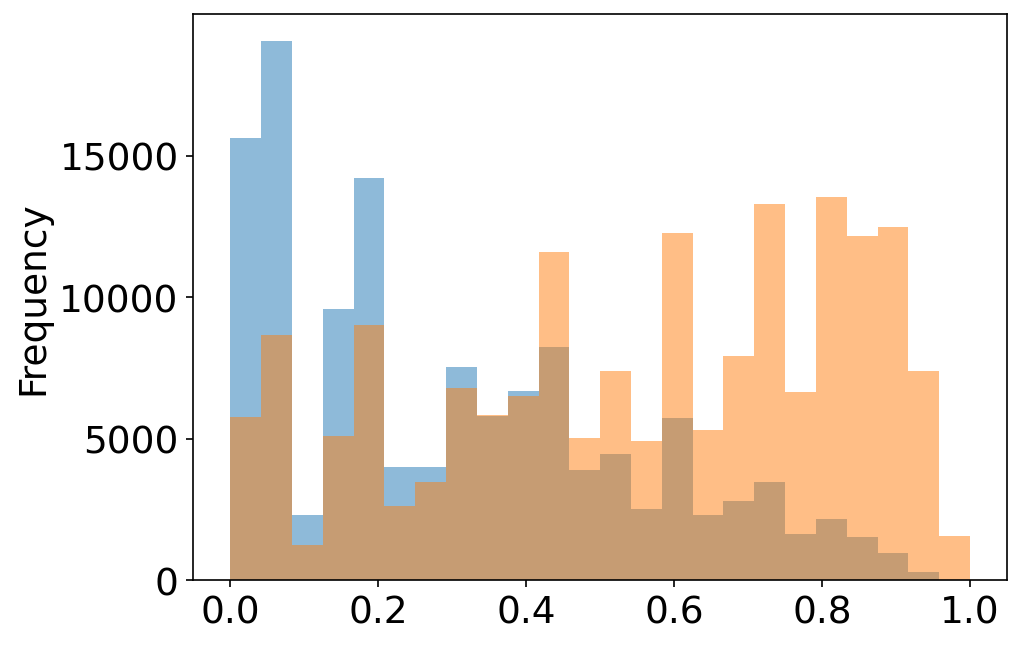

In [29]:
import numpy as np
ytrue = ytest.argmin(axis=1)
series_pred_test = pd.Series(pred_test)
bins = np.linspace(0,1,25)

for iclass in 0,1:
    mask = ytrue==iclass
    series_pred_test[mask].plot(kind="hist",alpha=0.5,bins=bins,weights=wtest[mask])

 

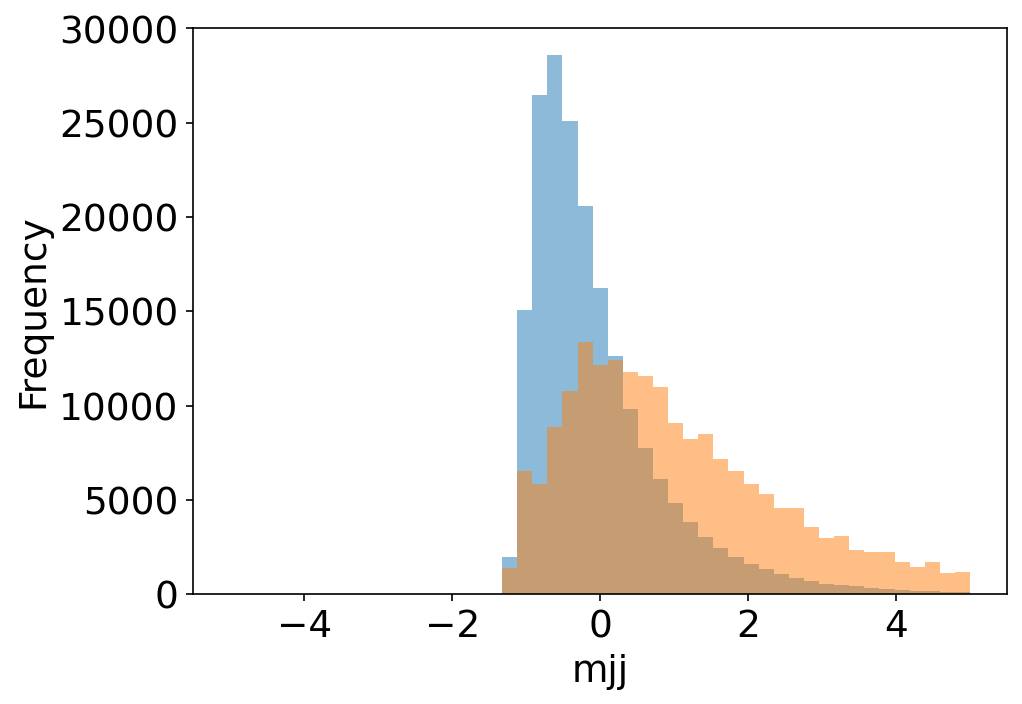

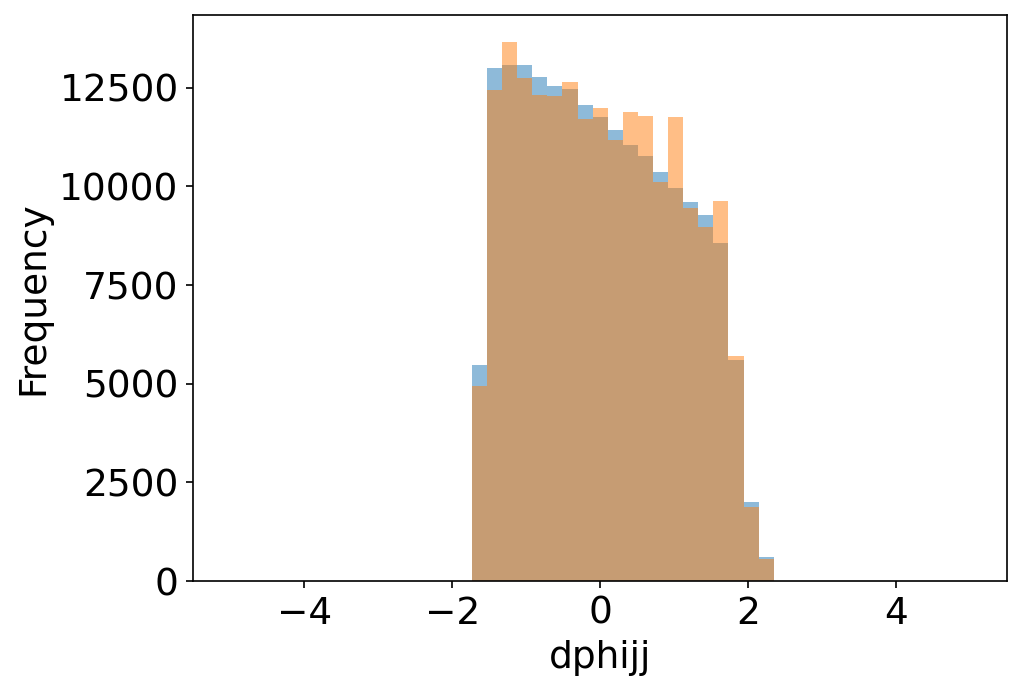

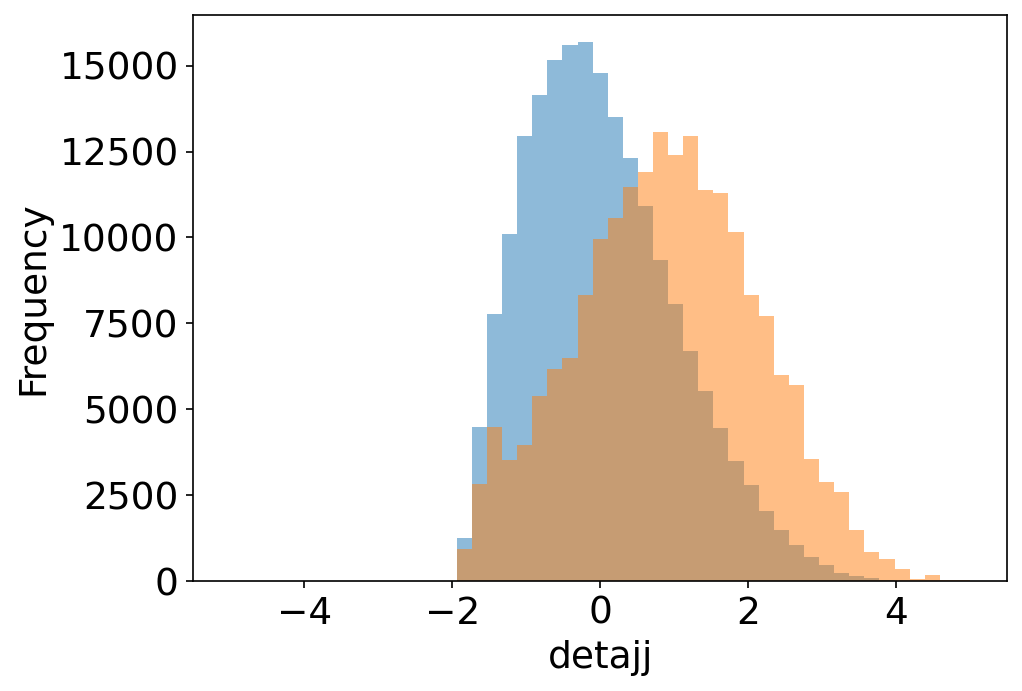

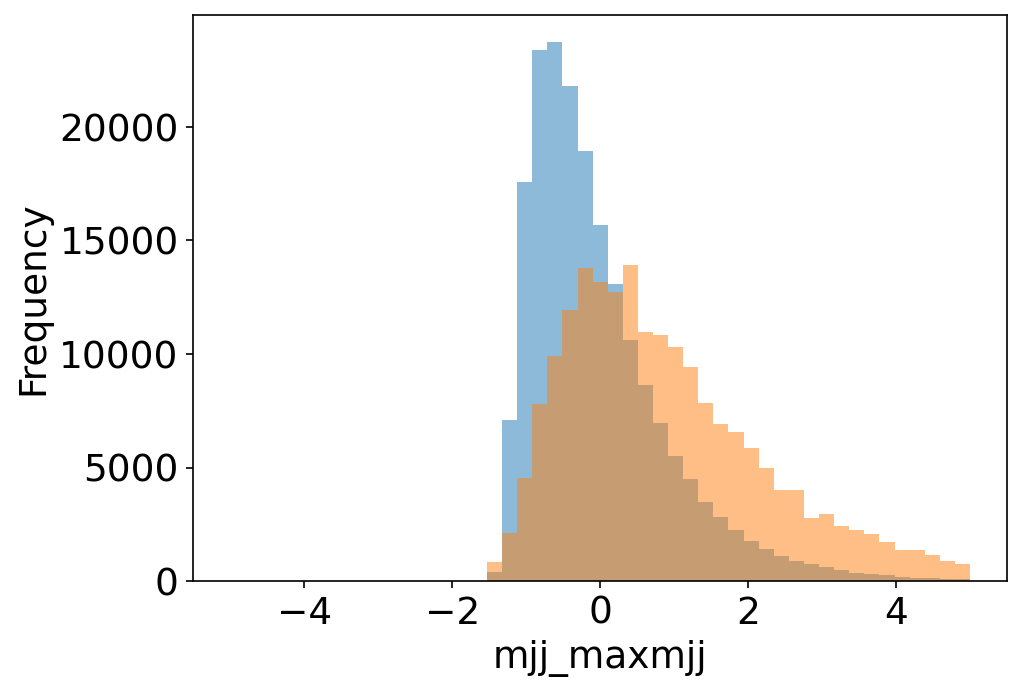

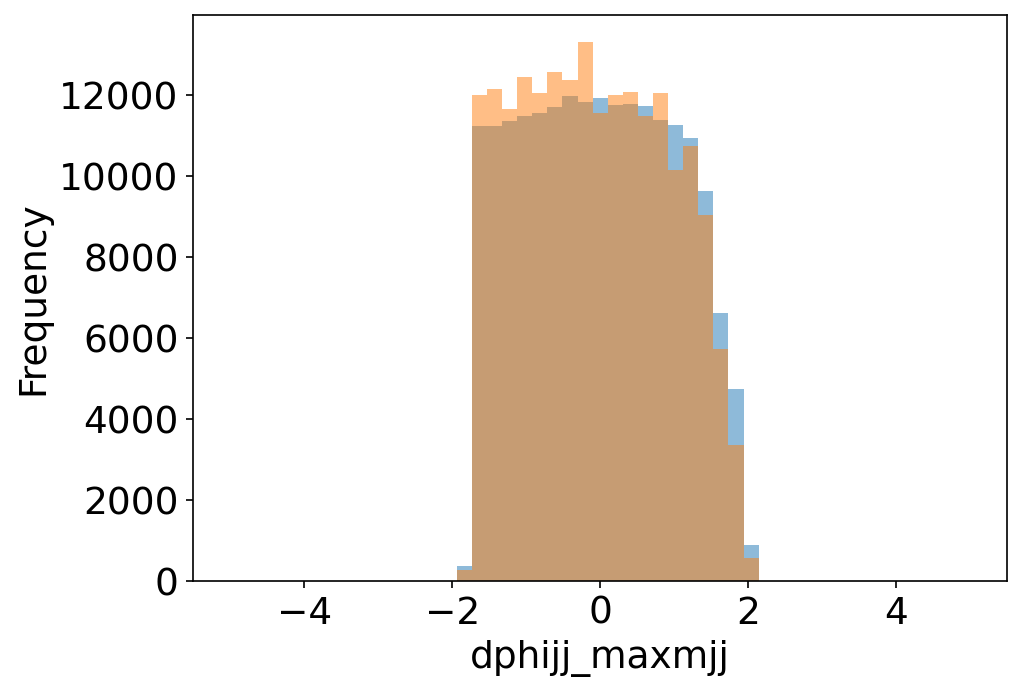

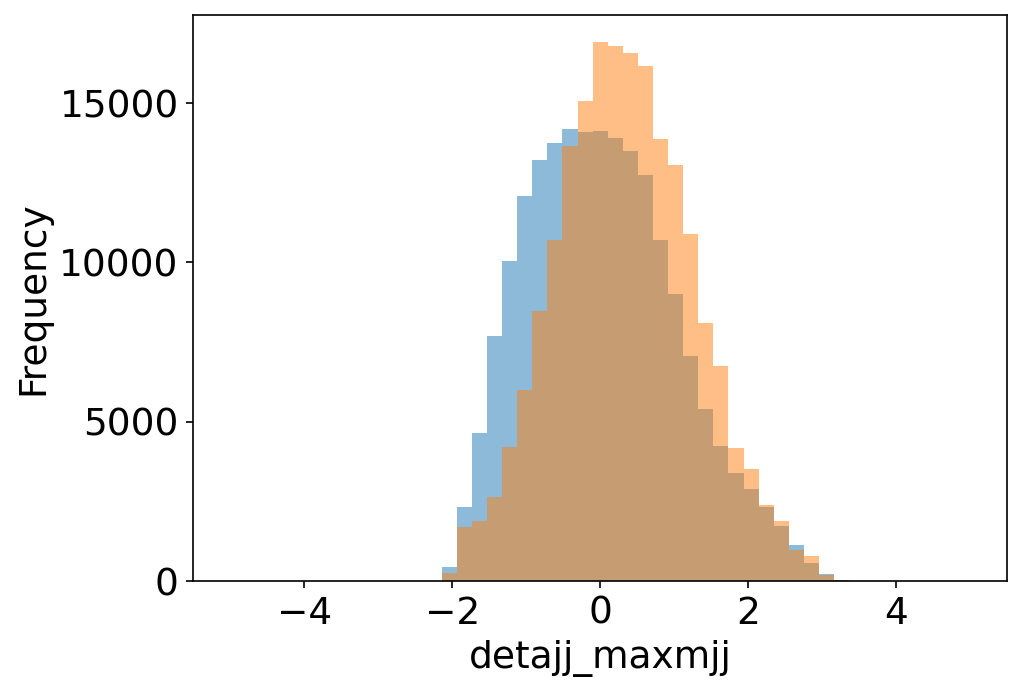

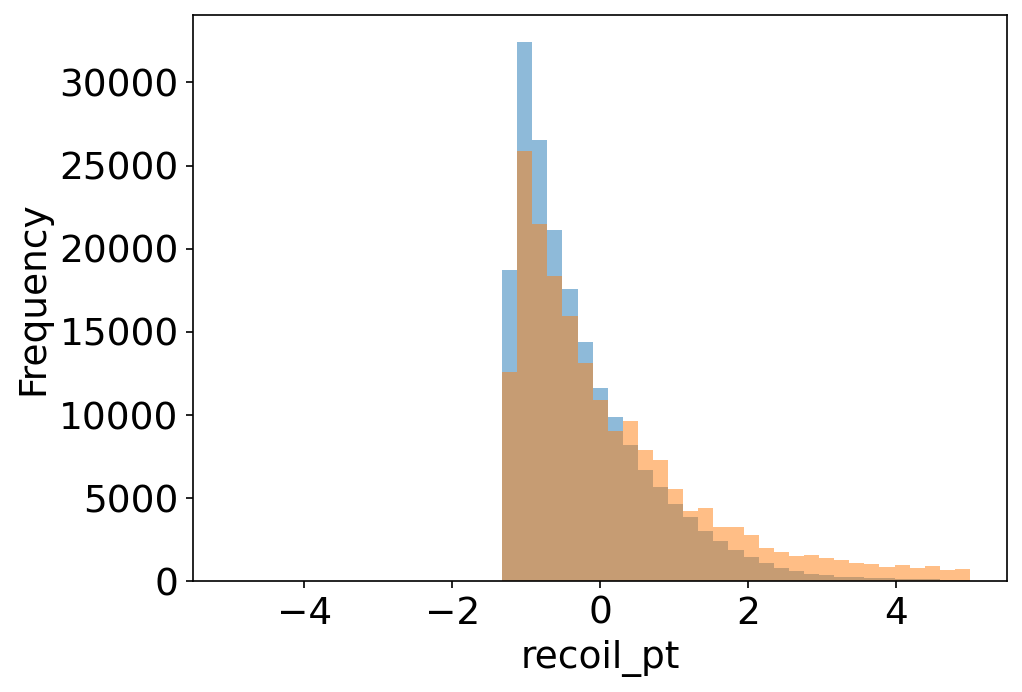

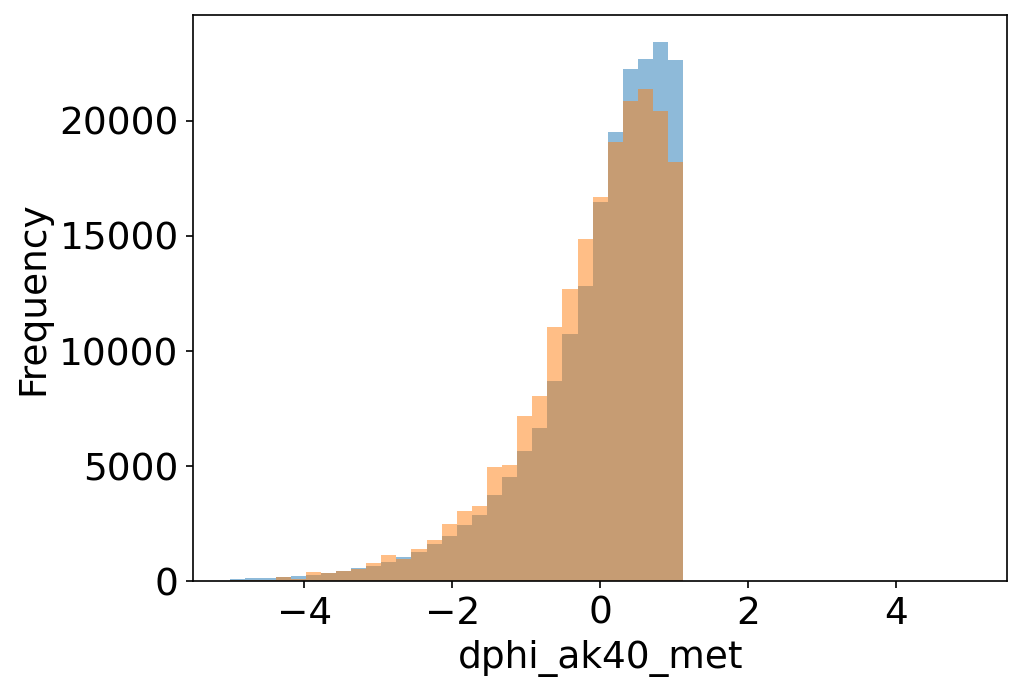

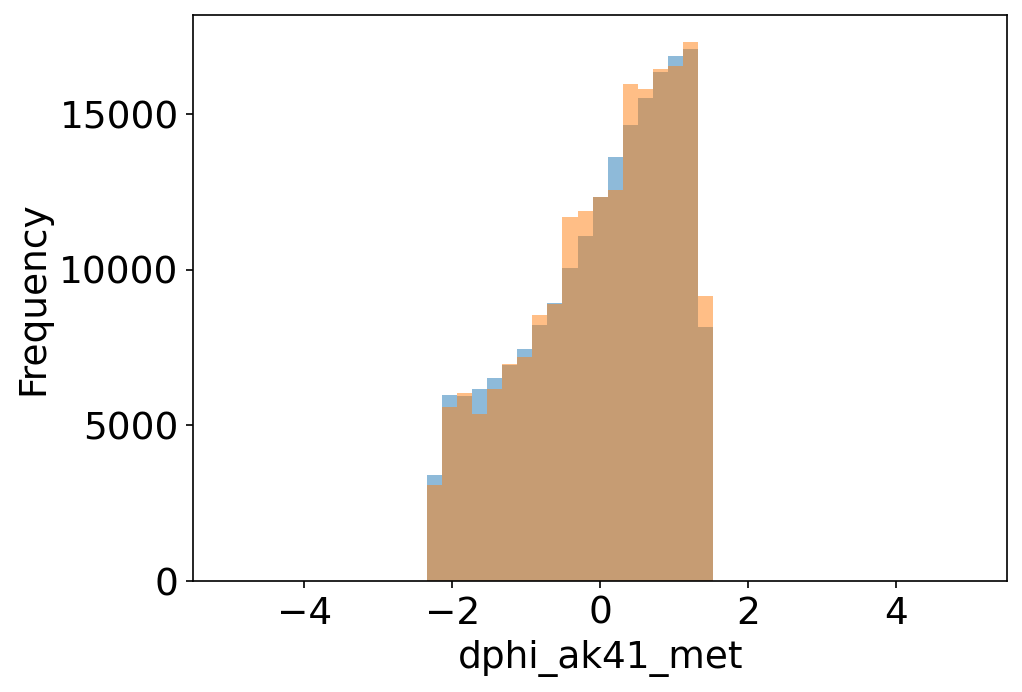

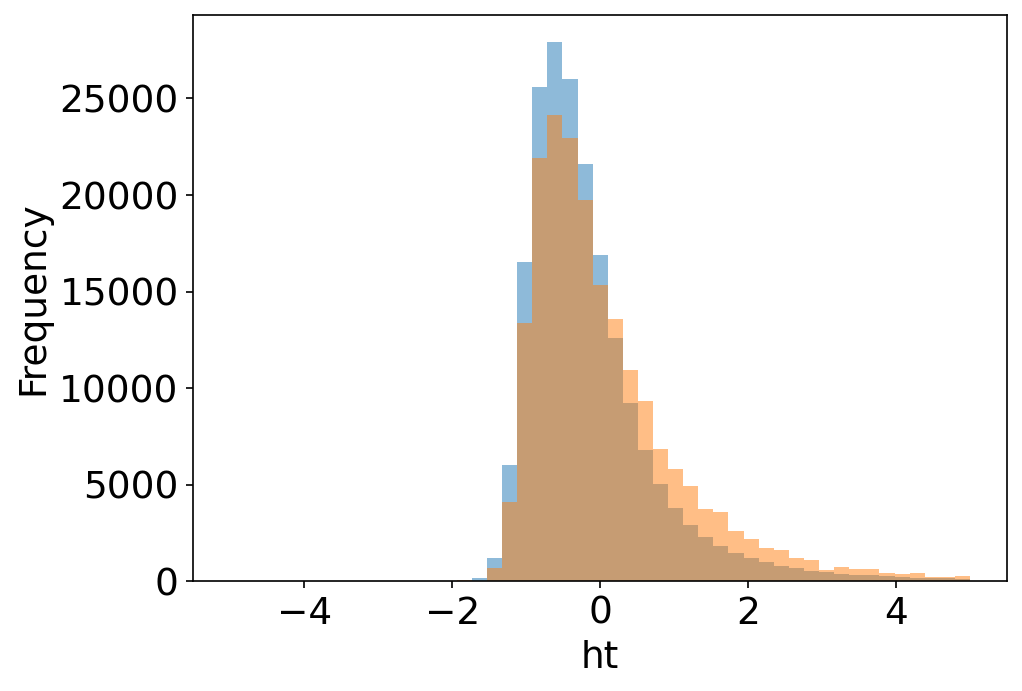

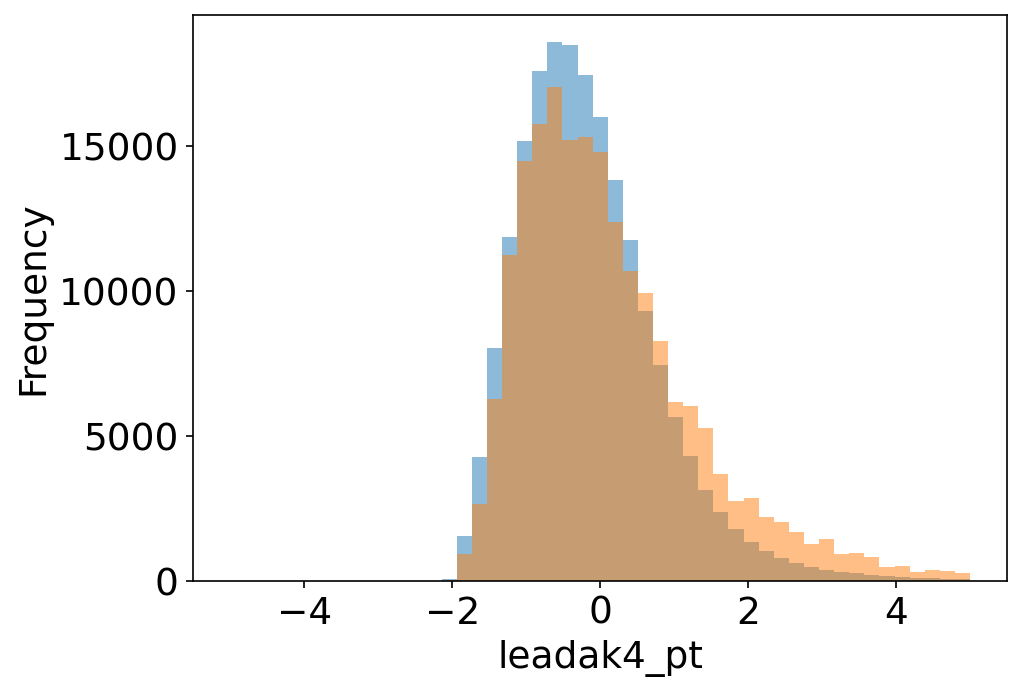

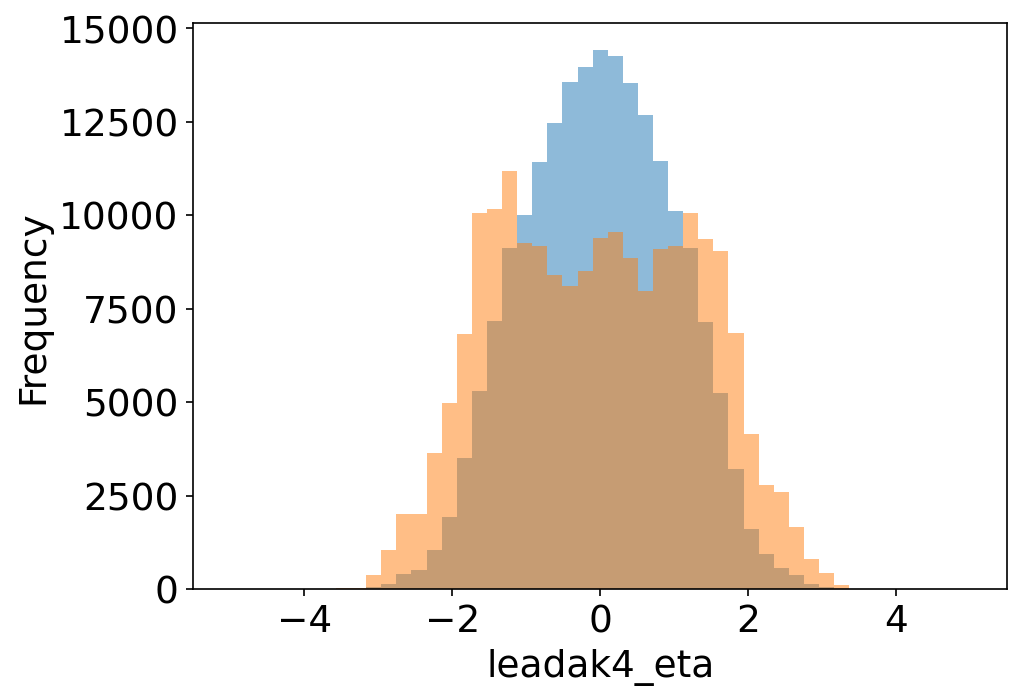

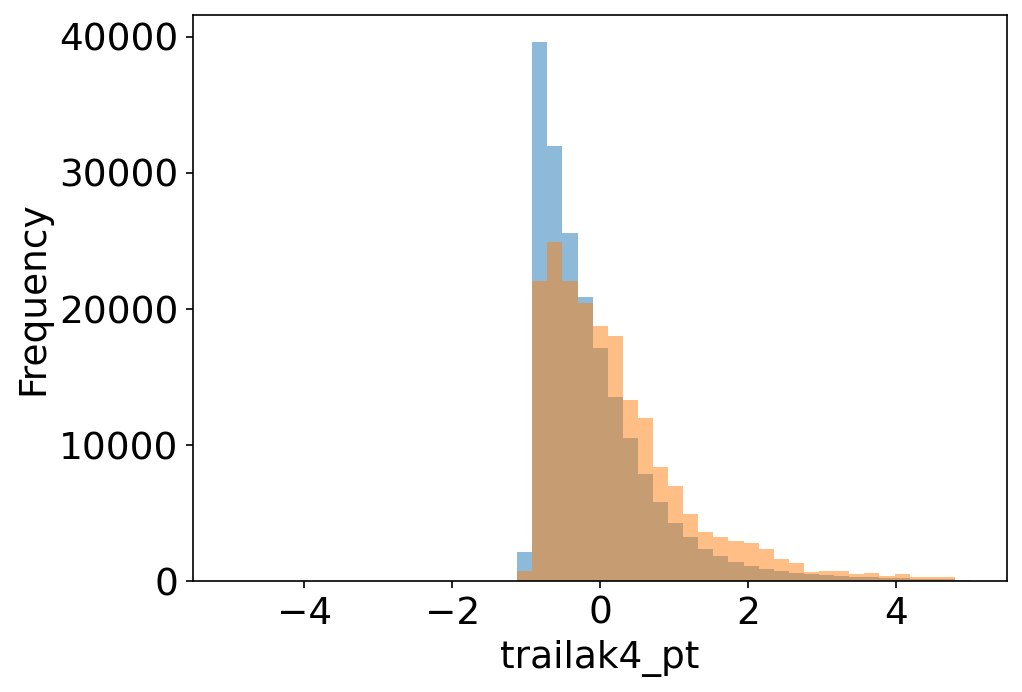

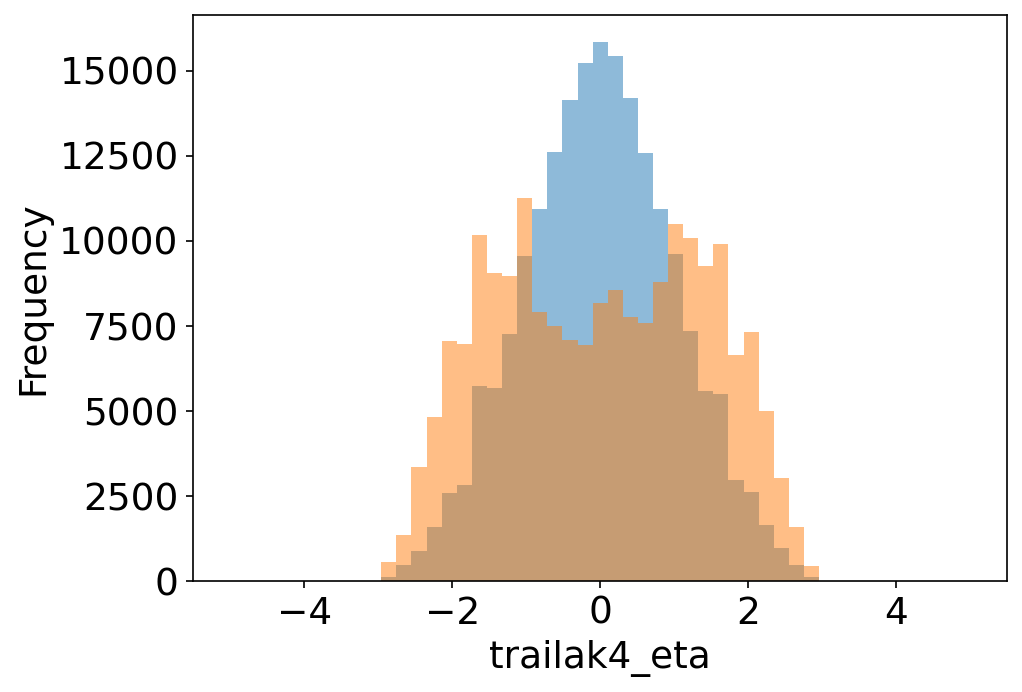

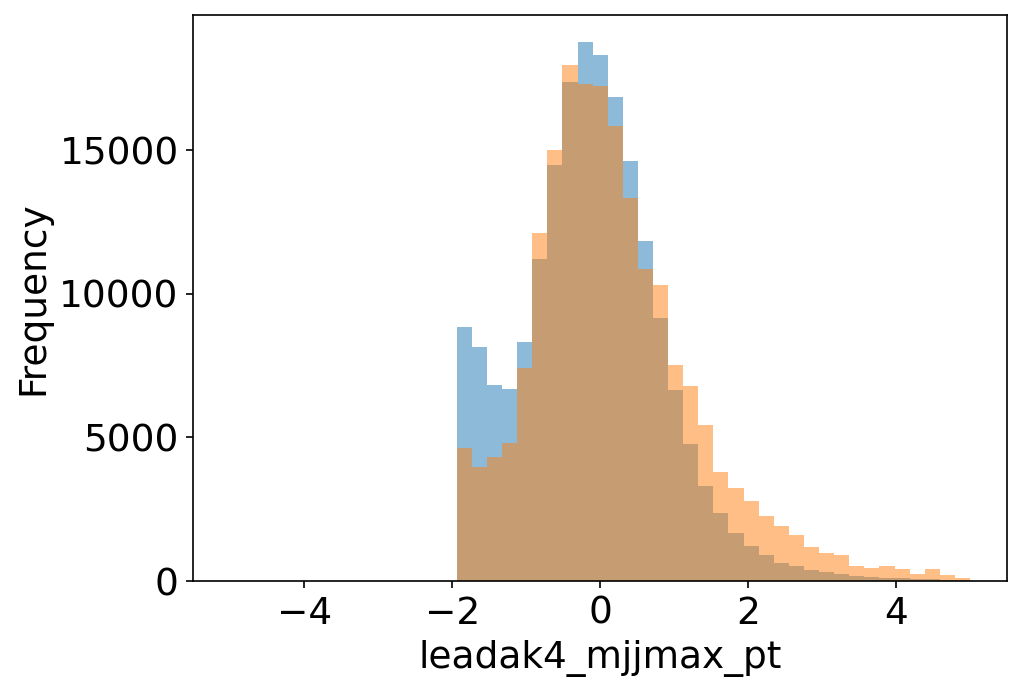

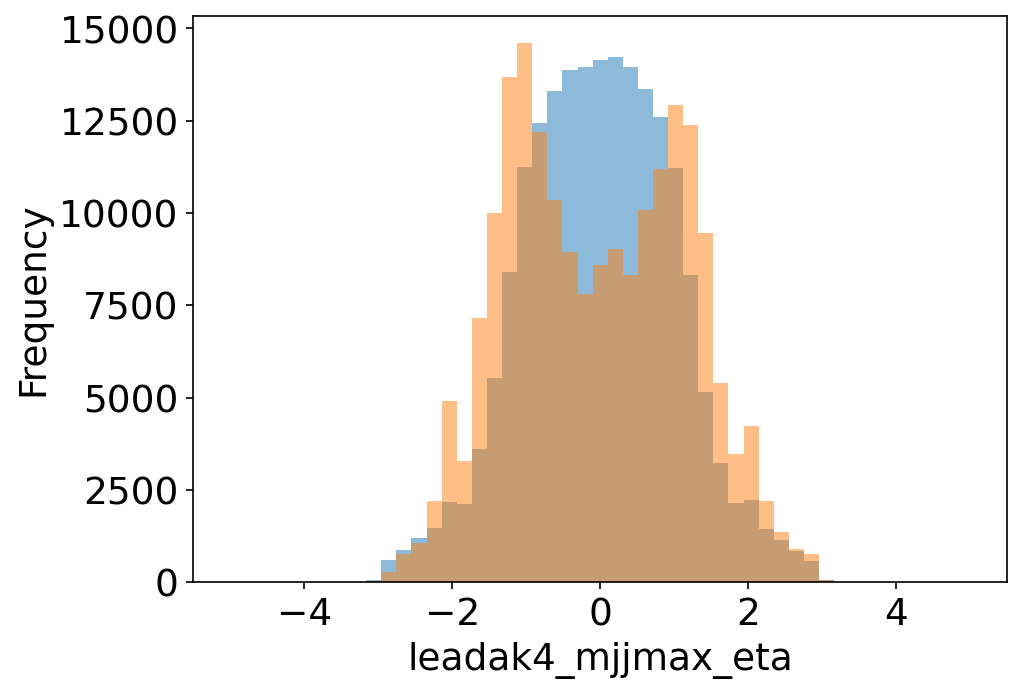

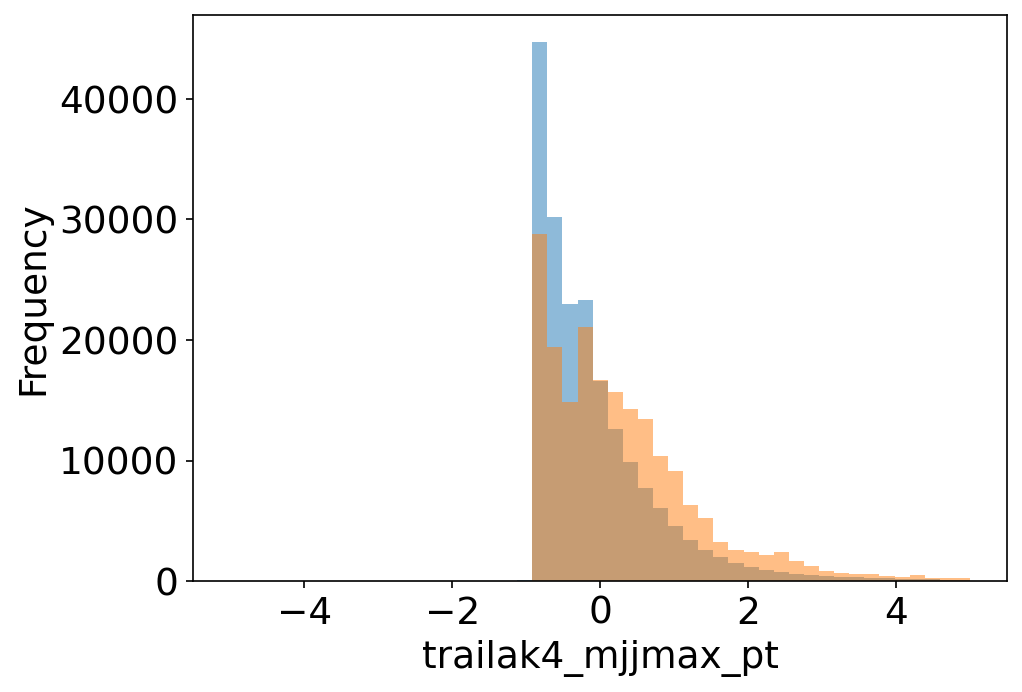

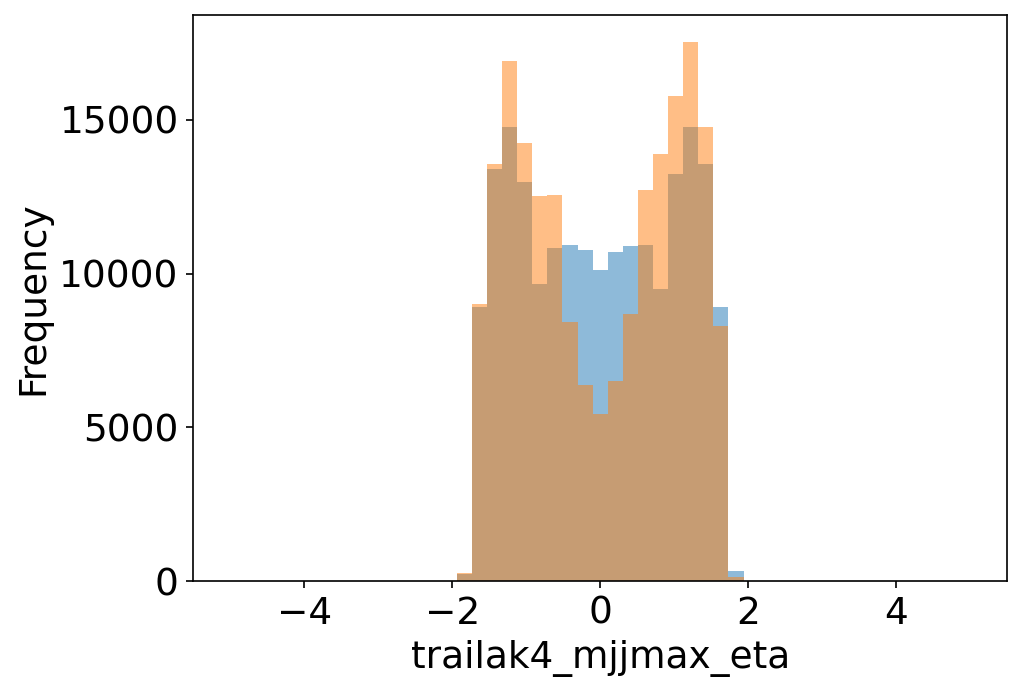

In [30]:
for ifeat, feature in enumerate(features):
    plt.figure()
    for iclass in 0,1:
        mask = ytrue==iclass
        pd.Series(xtest[:,ifeat][mask]).plot(kind="hist",alpha=0.5,bins=np.linspace(-5,5,50),weights=wtest[mask], label=f'Class {iclass}')
        plt.xlabel(feature)


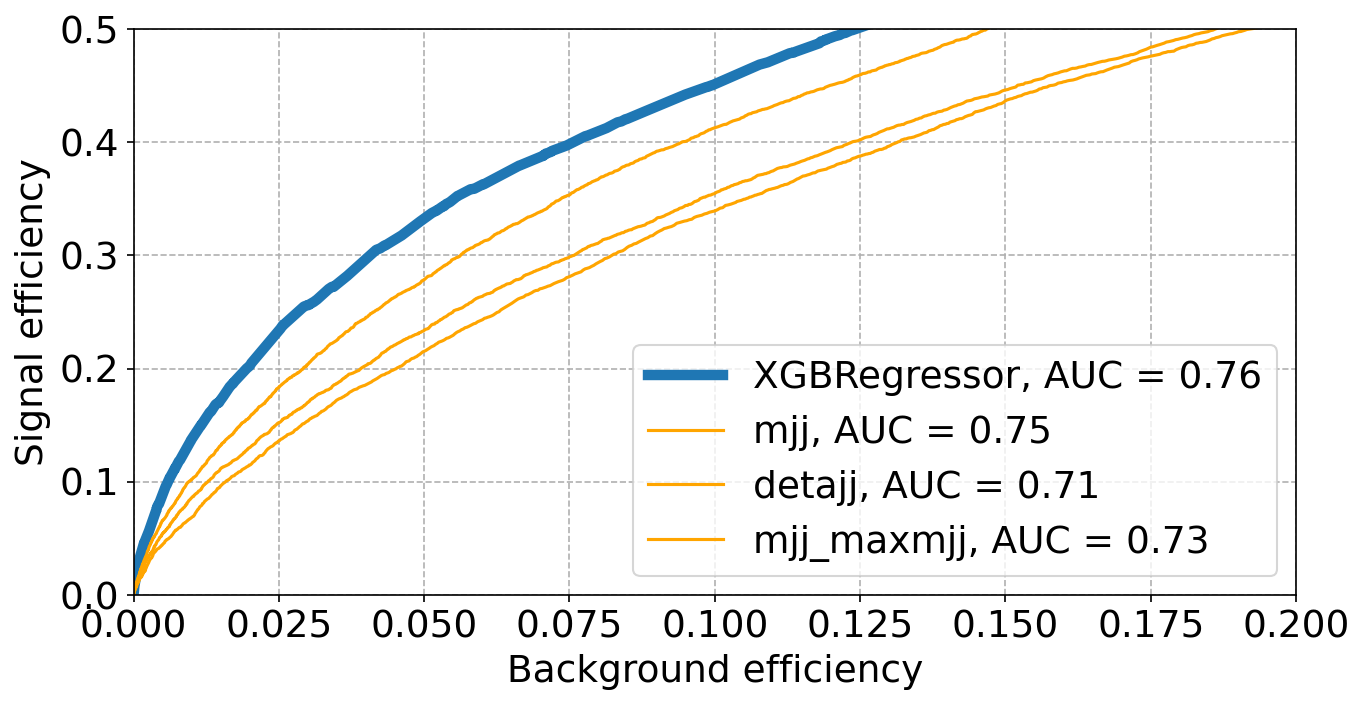

In [31]:
plt.figure(figsize=(10,5))
fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_true=ytest.argmin(axis=1), y_score=pred_test, sample_weight=wtest)
auc = sklearn.metrics.roc_auc_score(y_true=ytest.argmin(axis=1), y_score=pred_test, sample_weight=wtest)
plt.plot(fpr,tpr, label=f'XGBRegressor, AUC = {auc:.2f}',lw=5)


fprs = {}
tprs = {}

fprs['xgb'] = fpr

tprs['xgb'] = tpr

for ifeat, feature in enumerate(features):
    fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_true=ytest.argmin(axis=1), y_score=-xtest[:,ifeat], sample_weight=wtest)

    
    auc = sklearn.metrics.roc_auc_score(y_true=ytest.argmin(axis=1), y_score=-xtest[:,ifeat], sample_weight=wtest)
    if auc < 0.5:
        fpr = 1-fpr
        tpr = 1-tpr
        auc = 1-auc
    if auc<0.7:
        continue
    fprs[feature] = fpr
    tprs[feature] = tpr
    plt.plot(fpr,tpr, label=f'{feature}, AUC = {auc:.2f}',color='orange')
    
plt.ylabel("Signal efficiency")
plt.xlabel("Background efficiency")
plt.xlim(0,0.2)
plt.ylim(0,0.5)
plt.grid(ls='--')
plt.legend()

/tmp/ipykernel_3500/1056575350.py:10: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(x,f['xgb'](x)/f['mjj'](x))


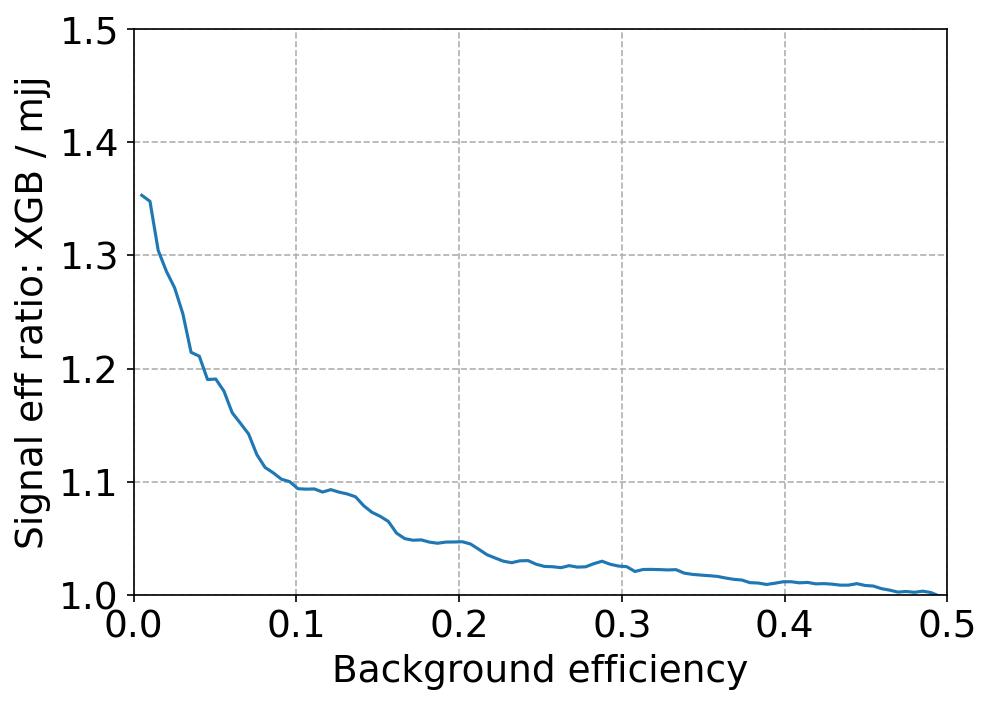

In [32]:
from scipy.interpolate import interp1d

f = {}

for feature in ['mjj','xgb']:
    f[feature] = interp1d(fprs[feature], tprs[feature])

x = np.linspace(0,0.5,100)

plt.plot(x,f['xgb'](x)/f['mjj'](x))

# plt.plot(fprs['mjj'], tprs['mjj'])
plt.xlabel("Background efficiency")
# plt.plot(fprs['xgb'], tprs['xgb'])

plt.ylabel("Signal eff ratio: XGB / mjj")
plt.ylim(1,1.5)
plt.xlim(0,0.5)
plt.grid(ls='--')